In [ ]:
from google.colab import drive
import os
import tifffile
from PIL import Image
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.data import Dataset
from tensorflow.keras.layers import Normalization
from tensorflow.keras import  Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Activation,\
    BatchNormalization, Dropout, MaxPooling2D,\
    Conv2D, concatenate, Conv2DTranspose
import albumentations as A
from tensorflow.keras import metrics
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images_dir = "/content/drive/MyDrive/data/images"
masks_dir = "/content/drive/MyDrive/data/labels"

In [ ]:
print(len(os.listdir(images_dir)))
print(len(os.listdir(masks_dir)))

306
456


In [ ]:
img_list=[]
mask_list=[]

image_files = sorted(os.listdir(images_dir))
mask_files = sorted(os.listdir(masks_dir))

for img_name in image_files:
  img_path = os.path.join(images_dir, img_name)
  mask_name = img_name.replace(".tif", ".png")
  mask_path = os.path.join(masks_dir, mask_name)

  img = tifffile.imread(img_path)
  mask = np.array(Image.open(mask_path))

  img_list.append(np.array(img,dtype=float))
  mask_list.append(np.array(mask,dtype=int))

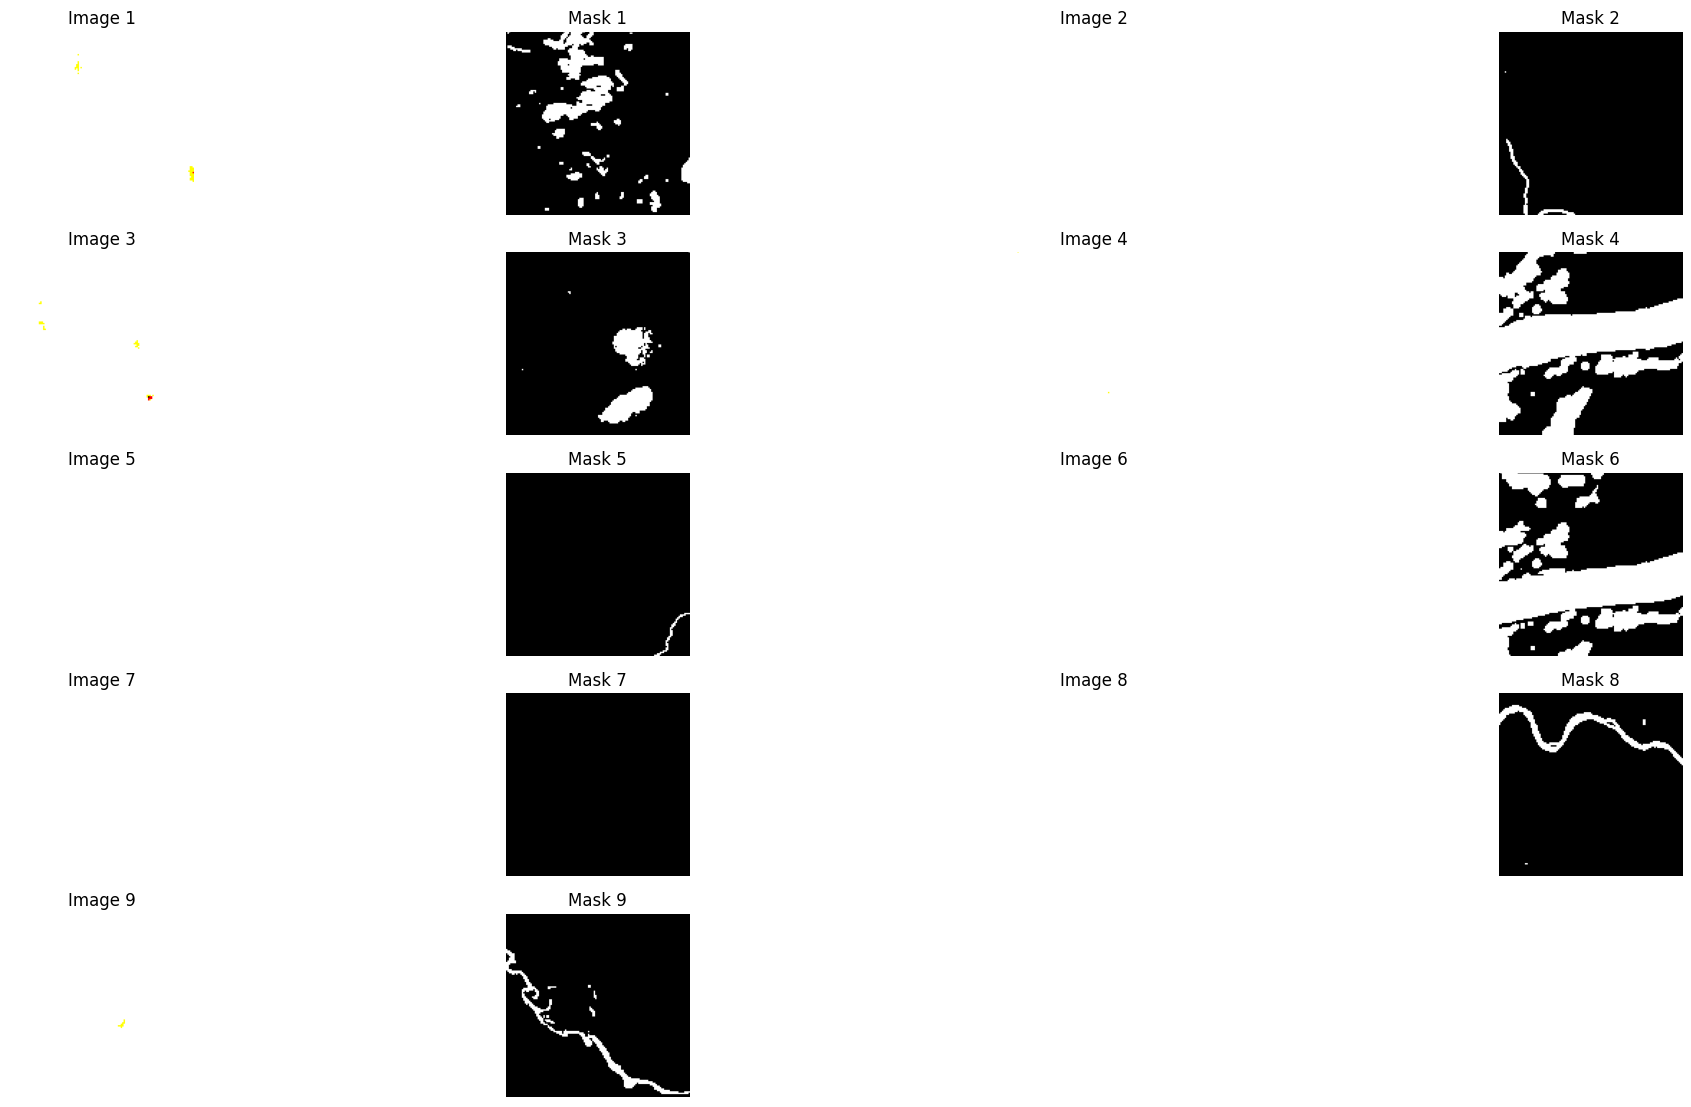

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(9):
    img = img_list[i]
    mask = mask_list[i]

    rgb = img[:, :, list((3,2,1))]

    plt.subplot(9, 4, 2*i+1)
    plt.imshow(rgb)
    plt.axis("off")
    plt.title(f"Image {i+1}")

    plt.subplot(9, 4, 2*i+2)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.title(f"Mask {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
def choose_channels(image):
    red     = img[..., 3]
    green   = img[..., 2]
    blue    = img[..., 1]
    nir     = img[..., 4]
    swir1   = img[..., 5]
    swir2   = img[..., 6]
    water_occur=img[...,-1]
    ndwi=(green-nir)/(green+nir)
    channels=[blue,red,ndwi,swir1,swir2,water_occur]
    image = np.stack(channels, axis=-1)
    return image


In [ ]:
img_list=[choose_channels(i) for i in img_list]

In [ ]:
numofchannels=img_list[0].shape[-1]

In [ ]:
for i in range(numofchannels):
  print(f"range before normailzation for channel {i} is {img_list[0][:,:,i].min()},{img_list[0][:,:,i].max()}")

range before normailzation for channel 0 is -167.0,1215.0
range before normailzation for channel 1 is 52.0,1493.0
range before normailzation for channel 2 is -0.8896787034404322,-0.1238702817650186
range before normailzation for channel 3 is 133.0,3311.0
range before normailzation for channel 4 is 67.0,1847.0
range before normailzation for channel 5 is 0.0,83.0


In [ ]:
dir={i: [np.inf, -np.inf] for i in range(numofchannels)}
for img in img_list:
  for i in range(numofchannels):
    dir[i][0]=min(img[:,:,i].min(),dir[i][0])
    dir[i][1]=max(img[:,:,i].max(),dir[i][1])

In [ ]:
dir

{0: [np.float64(-167.0), np.float64(1215.0)],
 1: [np.float64(52.0), np.float64(1493.0)],
 2: [np.float64(-0.8896787034404322), np.float64(-0.1238702817650186)],
 3: [np.float64(133.0), np.float64(3311.0)],
 4: [np.float64(67.0), np.float64(1847.0)],
 5: [np.float64(0.0), np.float64(83.0)]}

In [ ]:
for img in img_list :
  for i in range(numofchannels):
    img[:,:,i]=(img[:,:,i]-dir[i][0])/(dir[i][1]-dir[i][0])

In [ ]:
for i in range(numofchannels):
  print(f"range after normailzation for channel {i} is {img_list[0][:,:,i].min()},{img_list[0][:,:,i].max()}")

range after normailzation for channel 0 is 0.0,1.0
range after normailzation for channel 1 is 0.0,1.0
range after normailzation for channel 2 is 0.0,1.0
range after normailzation for channel 3 is 0.0,1.0
range after normailzation for channel 4 is 0.0,1.0
range after normailzation for channel 5 is 0.0,1.0


In [ ]:
train_imgs, temp_img, train_masks, temp_masks = train_test_split(
    img_list, mask_list, test_size=0.2, random_state=0
)
test_imgs, val_imgs, test_masks, val_masks = train_test_split(
    temp_img, temp_masks, test_size=0.5, random_state=0
)

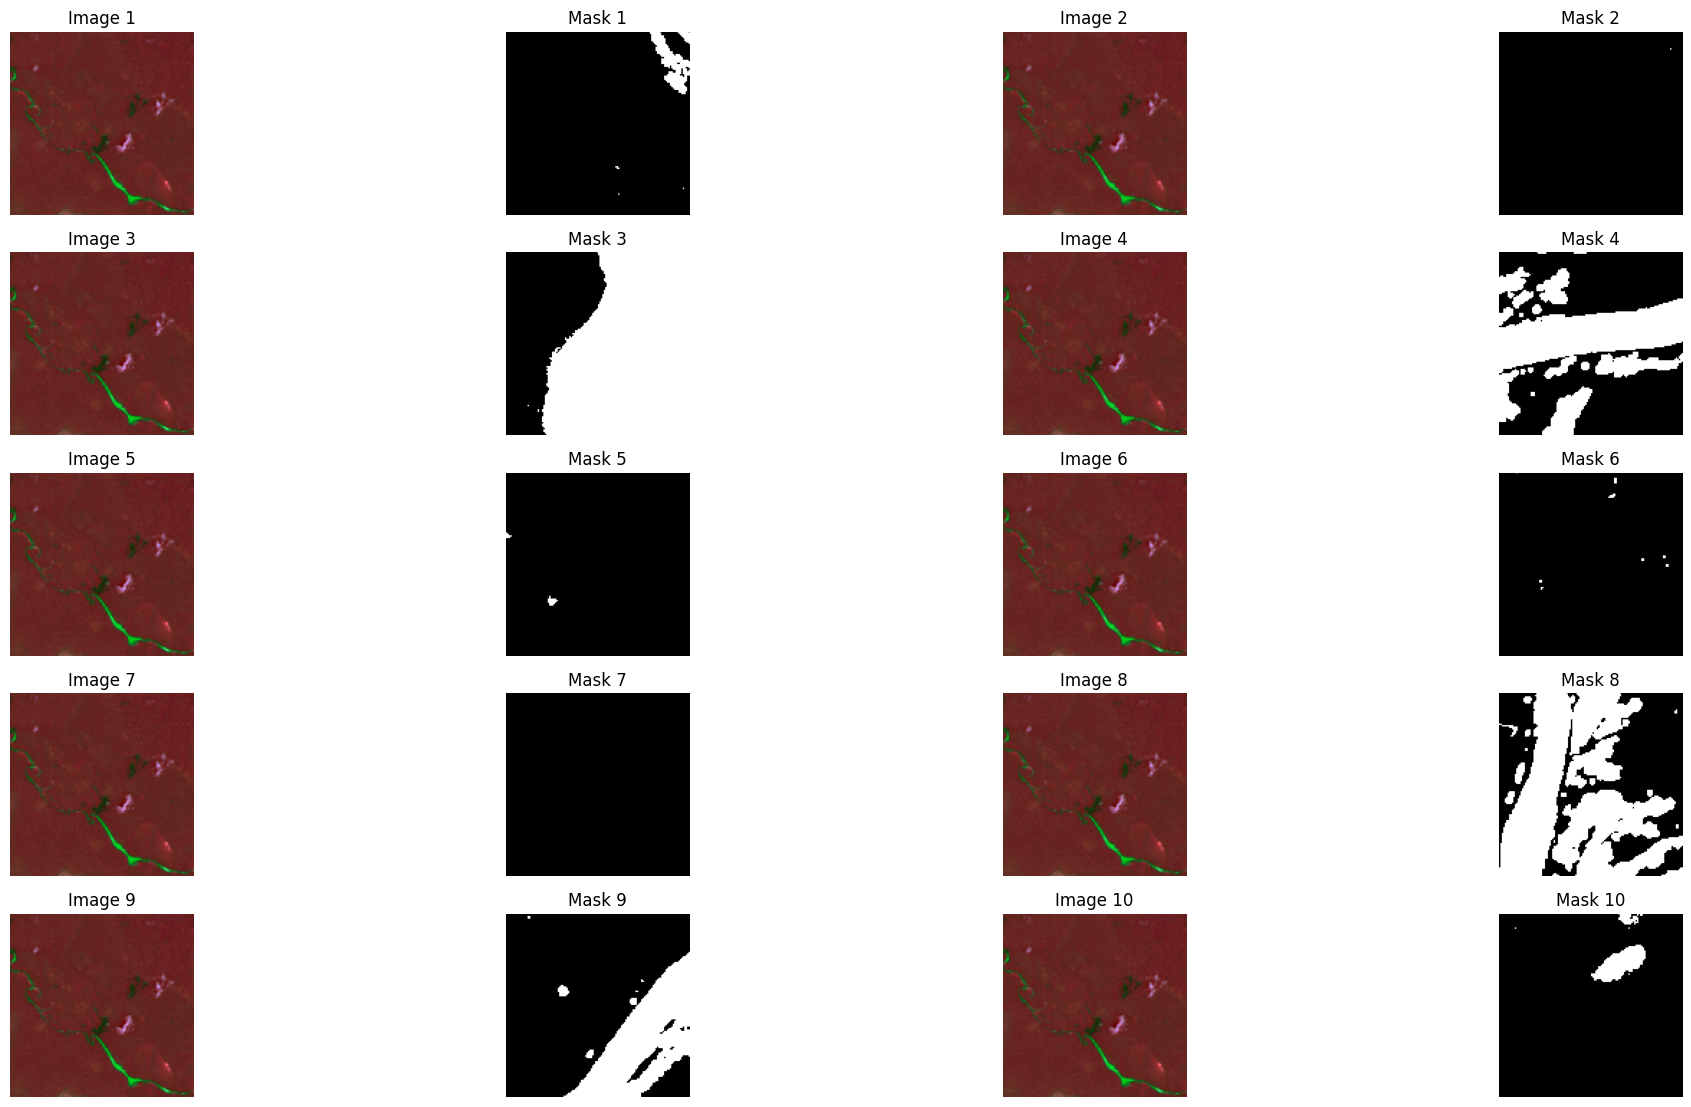

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(10):
    img = val_imgs[i]
    mask = val_masks[i]

    rgb = img[:, :, list((3,2,1))]

    plt.subplot(9, 4, 2*i+1)
    plt.imshow(rgb)
    plt.axis("off")
    plt.title(f"Image {i+1}")

    plt.subplot(9, 4, 2*i+2)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.title(f"Mask {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
len(train_imgs), len(val_imgs), len(test_imgs), len(train_masks),len(val_masks) ,len(test_masks)

(244, 31, 31, 244, 31, 31)

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5)
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
augmented_images = []
augmented_masks = []

for img, mask in zip(train_imgs, train_masks):
    augmented = transform(image=img, mask=mask)
    augmented_images.append(augmented['image'])
    augmented_masks.append(augmented['mask'])

train_imgs = train_imgs + augmented_images
train_masks = train_masks + augmented_masks


In [ ]:
print(f'shape of image {train_imgs[0].shape}'),print(f'shape of mask {train_masks[0].shape}')

shape of image (128, 128, 6)
shape of mask (128, 128)


(None, None)

In [ ]:
BASE_FILTERS = 32
INPUT_SIZE   = (128, 128, numofchannels)
DROPOUT      = 0
ACTIVATION   = 'relu'
INITIALIZER  = 'he_normal'

input_layer = Input(INPUT_SIZE)

c1 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (input_layer)
c1 = BatchNormalization()(c1)
c1 = Dropout(DROPOUT)(c1)
c1 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(DROPOUT)(c2)
c2 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(DROPOUT)(c3)
c3 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(DROPOUT)(c4)
c4 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(BASE_FILTERS * 16, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(DROPOUT)(c5)
c5 = Conv2D(BASE_FILTERS * 16, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(BASE_FILTERS * 8, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(DROPOUT)(c6)
c6 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(BASE_FILTERS * 4, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(DROPOUT)(c7)
c7 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(BASE_FILTERS * 2, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(DROPOUT)(c8)
c8 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(BASE_FILTERS, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(DROPOUT)(c9)
c9 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c9)

ouput_layer = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = Model(inputs=[input_layer], outputs=[ouput_layer])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      1,760 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_9[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_10[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_11[0][0]

 Total params: 7,772,609 (29.65 MB)

 Trainable params: 7,766,785 (29.63 MB)

 Non-trainable params: 5,824 (22.75 KB)

In [ ]:
iou = metrics.IoU(num_classes=2, target_class_ids=[0,1])

model.compile(
    optimizer = AdamW(learning_rate=1e-6, weight_decay=1e-4),
     loss = BinaryCrossentropy(),
    metrics=[iou]
)

In [ ]:
checkpoint = ModelCheckpoint(
    filepath='Water Segmentation.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [ ]:
type(train_imgs),type(train_masks),type(val_imgs),type(val_masks)

(list, list, list, list)

In [ ]:
history = model.fit(
    np.array(train_imgs),
    np.array(train_masks),
    validation_data=(np.array(val_imgs),np.array(val_masks)),
    batch_size=16,
    epochs=100,
    callbacks=[checkpoint]
)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - io_u_2: 0.3748 - loss: 1.0402
Epoch 1: val_loss improved from inf to 1.29159, saving model to Water Segmentation.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 580ms/step - io_u_2: 0.3747 - loss: 1.0408 - val_io_u_2: 0.3880 - val_loss: 1.2916
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - io_u_2: 0.3725 - loss: 1.0510
Epoch 2: val_loss did not improve from 1.29159
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - io_u_2: 0.3725 - loss: 1.0511 - val_io_u_2: 0.3880 - val_loss: 1.2919
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - io_u_2: 0.3652 - loss: 1.0532
Epoch 3: val_loss did not improve from 1.29159
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - io_u_2: 0.3654 - loss: 1.0534 - val_io_u_2: 0.3880 - val_loss: 1.2920
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - io_u_2: 0.3689 - loss: 1.0521
Epoch 4: val_loss improved from 1.29159 to 1.28990, saving model to Water Segmentation.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - io_u_2

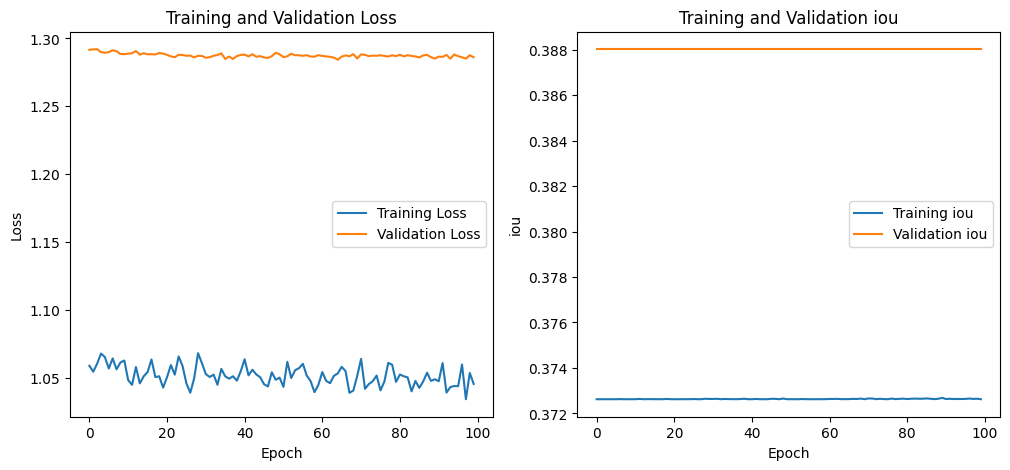

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['io_u_2'], label='Training iou')
plt.plot(history.history['val_io_u_2'], label='Validation iou')
plt.xlabel('Epoch')
plt.ylabel('iou')
plt.legend()
plt.title('Training and Validation iou')
plt.show()